# RNN 的高级用法

这里介绍提高 RNN 的性能和泛化能力的 3 种高级技巧。

- **<font color='red'>循环 dropout (recurrent dropout)</font>**。在循环层中使用 dropout 来降低 overfitting。


- **<font color='red'>堆叠循环层 (stacking recurrent layers)</font>**。提高 NN 的表示能力 (代价是更高的 computational loads)。


- **<font color='red'>双向循环层(bidirectional recurrent layer)</font>**。将相同的信息以不同的方式呈现给 RNN，可以提高精度并缓解遗忘问题。

## 1. 定义问题

这里使用一个天气时间序列[数据集](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)。在这个数据集中，每 10 分钟记录 14 个不同的量 (如气温、气压、湿度、风向等)，其中包含多年的数据。原始数据可追溯到 2003 年，但本例仅使用 2009—2016 年的数据。

**这个数据集非常适合用来学习处理数值型时间序列。**

**用这个数据集来构建模型，输入最近的一些数据 (几天的数据点)，可以预测 24 小时之后的气温。**

In [1]:
# Common imports
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
tf.random.set_seed(42)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
# Raw data
data_dir = '/home/libing/datasets/jena_climate'
data_path = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
!head -n 3 /home/libing/datasets/jena_climate/jena_climate_2009_2016.csv

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10


In [29]:
# Load the data
data = pd.read_csv(data_path)
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [30]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


数据中共有 420551 条数据，每一行是一个 timestep，记录了一个日期和 14 与天气有关的值。

In [31]:
# Parse the data
float_data = data.values[:, 1:]
# 不然预处理时会出错
float_data = float_data.astype('float64')

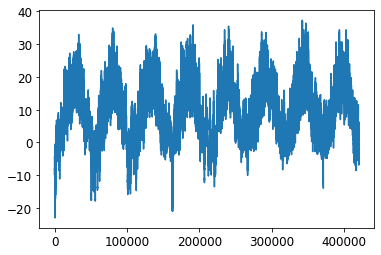

In [32]:
# 温度随时间的变化曲线
temp = float_data[:, 1]  # temperature
plt.plot(temp)
plt.show()

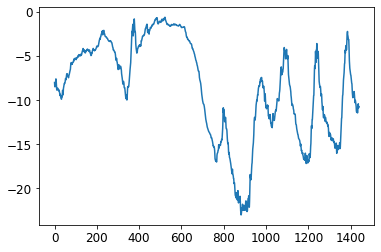

In [33]:
# 绘制前 10 天的温度时间序列
plt.plot(temp[:1440])
plt.show()

每 10 分钟记录一次，1 天 24x6=144 条数据，10 天 1440 条数据。

可以看到每天的周期性变化，尤其是最后 4 天特别明显。这 10 天一定是来自于很冷的冬季月份。

**如果想根据过去几个月的数据来预测下个月的平均温度，那么问题很简单，因为数据具有可靠的年度周期性。**但从几天的数据来看，温度看起来更混乱一些。以天作为观察尺度，这个时间序列是可以预测的吗？

**<font color='blue'>问题：</font>** 一个时间步是 10 分钟，每 steps 个时间步采样一次数据，给定过去 lookback 个时间步内的数据，能否预测 delay 个时间步之后的温度？

- `lookup=720`：给定过去 5 天内的观测数据


- `steps=6`：观测数据的采样频率是每小时一个数据点


- `delay=144`：目标是未来 24 小时之后的数据

## 2. 准备数据

In [34]:
# 数据预处理——让特征在相似的范围内都取较小的特征
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

编写一个 Python 生成器，以当前的浮点数数组作为输入，并从最近的数据中生成数据批量，同时生成未来的目标温度。

**因为数据集中的样本是高度冗余的 (对于第 N 个样本和 第 N+1 个样本，大部分时间步都是相同的)，所以显式地保存每个样本是一种浪费。相反，我们将使用原始数据即时生成样本。**

In [46]:
def load_and_process_data(file_path=data_path):
    data = pd.read_csv(file_path)

    float_data = data.values[:, 1:]
    # 不然预处理时会出错
    float_data = float_data.astype('float64')

    # 数据预处理——让特征在相似的范围内都取较小的特征
    mean = float_data[:200000].mean(axis=0)
    float_data -= mean
    std = float_data[:200000].std(axis=0)
    float_data /= std

    return float_data

In [47]:
floa_data = load_and_process_data()

In [48]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False,
              batch_size=128, step=6):
    """生成一个元组 (samples, targets)。

    其中 samples 是输入数据的一个 batch，targets 是对应的目标温度数据。

    Parameters
    ----------
    data: np.array, 原始数据
    lookback: 输入数据应该包括过去多少个时间步
    delay: 目标应该在未来多少个时间步之后
    min_index 和 max_index: data 数组中的索引，用于界定需要抽取哪些时间步
    shuffle: 是否打乱数据。默认按顺序抽取数据
    batch_size: 每个 batch 的样本数
    step: 数据采样的周期/时间步。默认，每小时 (6 个时间步) 抽取一个数据点
    """
    # 确保在生成样本时，每个时间步之后都有 delay 个时间步数据，用于生成 target
    if max_index is None:
        max_index = len(data) - delay - 1

    i = min_index + lookback  # 可以生成样本的起始时间步

    while True:
        if shuffle:  # 打乱数据，在范围内随机生成 batch_size 个时间步来生成样本
            rows = np.random.randint(i, max_index, size=batch_size)
            # rows = np.random.randint(min_index+lookback, max_index, size=batch_size)  # 原文代码
        else:
            # 如果超出 max_index，则从头开始
            # 为了可以一直生成数据，每次调用这个函数结果都是一样的
            if i + batch_size >= max_index:  # 神来之笔
                i = min_index + lookback
            # 生成 rows 数组，其范围从第 i 个时间步到第 i+batch_size 个时间步
            rows = np.arange(i, i+batch_size)
            # rows = np.arange(i, min(i+batch_size, max_index))  # 原文代码
            i += len(rows)

        # shape (batch_size, 采样数, 特征值)
        samples = np.zeros(shape=(len(rows),
                                  lookback // step,  # 每 step 采样一次数据
                                  data.shape[-1]))
        targets = np.zeros(shape=(len(rows), ))
        for j, row in enumerate(rows):
            # 在第 row 个时间步时，每隔 step 个时间步来采样过去 lookback 个时间步内的数据
            indices = range(row-lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row+delay][1]  # 第 row+delay 个时间步的温度作为 target
        yield samples, targets

In [52]:
lookback = 1440   # 输入数据应该包括过去多少个时间步
step = 6          # 数据采样的周期/时间步。每小时 (6 个时间步) 抽取一个数据点
delay = 144       # 目标应该在未来多少个时间步之后
batch_size = 128  # 每个 batch 的样本数


train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 需要从 val_gen 生成多少次数据才能查看整个验证集
val_steps = (300000 - 200001 - lookback) // batch_size


# 为了查看整个测试集，需要从 test_gen 生成多少次数据
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 3. 基于常识的、非 ML 基准方法

在开始尝试 DL 模型之前，可以先尝试一种基于常识的简单方法。

<font color='crimson'>基于常识的基准方法可以作为合理性检查，还可以建立一个基准，更高级的 ML 模型需要打败这个基准才能表现出其有效性。面对一个尚没有已知解决方案的新问题时，这种基于常识的基准方法很有用。</font>

> 一个经典的例子就是不平衡的分类任务，其中某些类别比其他类别更常见。如果数据集中包含 90% 的类别 A 实例和 10% 的类别 B 实例，那么分类任务的一种基于常识的方法就是对新样本始终预测类别 “A”。这种分类器的总体精度为 90%，因此任何基于学习的方法在精度高于 90% 时才能证明其有效性。

有时候，这样基本的基准方法可能很难打败。

这里，温度时间序列是连续的 (明天的温度很可能接近今天的温度)，并且具有每天的周期性变化。因此，<font color='crimson'>一种基于常识的方法就是始终预测 24 小时后的温度等于现在的温度。</font>

使用平均绝对误差 (MAE) 指标来评估这种方法。

In [53]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]  # 现在的温度作为 24 小时之后的温度
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [54]:
evaluate_naive_method()

0.28973597299054815


因为温度数据被标准化成均值为 0、标准差为 1，所以无法直接对这个值进行解释。它转化成温度的平均绝对误差为`0.29×temperature_std` 摄氏度，即 2.57°C。

In [56]:
# 将 MAE 转换为温度
0.29 * std[1]

2.567224733839344

## 4. 一种基本的 ML 方法

<font color='crimson'>开始研究复杂且计算代价很高的模型 (比如 RNN) 之前，尝试使用简单且计算代价低的 ML  模型也是很有用的，比如小型的密集连接网络。这可以保证进一步增加问题的复杂度是合理的，并且会带来真正的好处。</font>